# 05.5 - Evaluate Auto Tuned Prompts

In this notebook, we will evaluate the performance of the prompts tuned by the test models. For this evaluation, we will evlauate inter-model agrement, as well as look at the performance of prompts tuned by a each model against the other models.

In [1]:
from genscai.prompts import PromptCatalog
from genscai import paths

catalog = PromptCatalog(paths.data / "prompt_catalog.db")
model_ids = catalog.retrieve_model_ids()
model_ids

['ollama:llama3.2:3b',
 'ollama:llama3.1:8b',
 'meta-llama/Meta-Llama-3.1-8B-Instruct',
 'microsoft/phi-4',
 'google/gemma-2-9b-it',
 'mistralai/Mistral-Nemo-Instruct-2407',
 'openai:gpt-4o-mini',
 'openai:gpt-4o']

In [2]:
import textwrap

for model_id in model_ids:
    print(f"model: {model_id}")

    prompt = catalog.retrieve_last(model_id)
    print(f"prompt revision: {prompt.version}")
    print(f"prompt metrics {prompt.metrics}")
    print(textwrap.fill(f"prompt: {prompt.prompt}", 100))
    print()

model: ollama:llama3.2:3b
prompt revision: 53
prompt metrics {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0}
prompt: Read the following scientific paper abstract and note any language or content that
explicitly suggests or utilizes mathematical, statistical, or computational methods used to
simulate, analyze, predict, or interpret the dynamics of infectious outbreaks in specific geographic
regions with a focus on estimating the probability of resurgence, understanding the effectiveness of
novel intervention strategies, prioritizing care from a utilitarian perspective (minimizing
population health loss), and comparing different scenarios of delay or no intervention, specifically
through disease modeling techniques such as compartmental models, parameter estimation, sensitivity
analysis, simulation modeling, time-series analysis, Bayesian inference, Monte Carlo simulations,
and other advanced statistical techniques to inform evidence-based decision-making in the context of
analyzing e

## Delete poorly performing prompts from catalog

If there are prompts that poor performing and they should't be use for future analysis, they can be removed from the catalog.

In [ ]:
# catalog.delete_all("ollama:qwen2.5:7b")

## Classify the entire corpus using each of the local models.

The following script classifies all of the papers in the corpus using each of the local models. This takes a long time, since the full corpus is large. The script outputs four files (data/modeling_papers_N.json). Unless you'd like to re-run the classifications, ignore the following cell and continue with the analyses.

In [ ]:
# !python $paths.root/scripts/06_classification_all_models.py

## Evaluate inter-model agreement

In [26]:
from genscai.models import HuggingFaceClient
import pandas as pd

MODEL_IDS = [
    HuggingFaceClient.MODEL_LLAMA_3_1_8B,
    HuggingFaceClient.MODEL_GEMMA_2_9B,
    HuggingFaceClient.MODEL_PHI_4_14B,
    HuggingFaceClient.MODEL_MISTRAL_NEMO_12B,
]

data = []
for i, model_id in enumerate(MODEL_IDS):
    df = pd.read_json(paths.data / f"modeling_papers_{i}.json", orient="records", lines=True)
    data.append(df)

In [27]:
from genscai.data import load_midas_data

df1, df2, df3 = load_midas_data()
df_all = pd.concat([df1, df2, df3])

In [28]:
rates = [[0] * len(data) for _ in [0] * len(data)]

print(f"total: {len(df_all)}")

for i in range(len(data)):
    for j in range(len(data)):
        df_intersection = pd.merge(data[i], data[j], how="inner", on=["id"])
        df_union = pd.merge(data[i], data[j], how="outer", on=["id"])

        rates[i][j] = (len(df_all) - len(df_union) + len(df_intersection)) / len(df_all)

        print(
            f"{MODEL_IDS[i]}, {MODEL_IDS[j]}: intersection={len(df_intersection)}, union={len(df_union)}, agreement_rate={rates[i][j]:.3f}"
        )

df = pd.DataFrame(data=rates, index=MODEL_IDS, columns=MODEL_IDS)

total: 11960
meta-llama/Meta-Llama-3.1-8B-Instruct, meta-llama/Meta-Llama-3.1-8B-Instruct: intersection=5737, union=5737, agreement_rate=1.000
meta-llama/Meta-Llama-3.1-8B-Instruct, google/gemma-2-9b-it: intersection=5310, union=6543, agreement_rate=0.897
meta-llama/Meta-Llama-3.1-8B-Instruct, microsoft/phi-4: intersection=3424, union=5843, agreement_rate=0.798
meta-llama/Meta-Llama-3.1-8B-Instruct, mistralai/Mistral-Nemo-Instruct-2407: intersection=4920, union=6756, agreement_rate=0.846
google/gemma-2-9b-it, meta-llama/Meta-Llama-3.1-8B-Instruct: intersection=5310, union=6543, agreement_rate=0.897
google/gemma-2-9b-it, google/gemma-2-9b-it: intersection=6116, union=6116, agreement_rate=1.000
google/gemma-2-9b-it, microsoft/phi-4: intersection=3492, union=6154, agreement_rate=0.777
google/gemma-2-9b-it, mistralai/Mistral-Nemo-Instruct-2407: intersection=5084, union=6971, agreement_rate=0.842
microsoft/phi-4, meta-llama/Meta-Llama-3.1-8B-Instruct: intersection=3424, union=5843, agreemen

<Axes: >

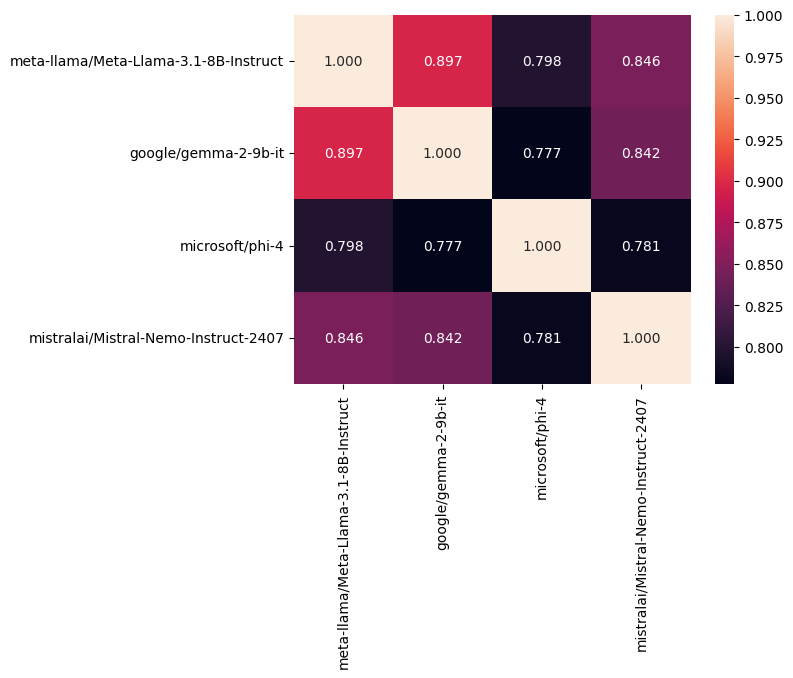

In [29]:
import seaborn as sns

sns.heatmap(df, annot=True, fmt=".3f")

In [59]:
import genscai.paths as paths
import pandas as pd
import json

dfs = {'precision': pd.DataFrame(), 'recall': pd.DataFrame(), 'accuracy': pd.DataFrame()}

with open(paths.data / "inter_model_results.txt", "r") as fin:
    for line in fin:
        if line.startswith('prompt'):
            line = line.strip()
            parts = line.split(', ')

            parts[0] = parts[0][len('prompt: '):]
            parts[1] = parts[1][len('model: '):]
            parts[2] = parts[2][len('metrics: '):]

            metrics = ', '.join(parts[2:])
            metrics = metrics.replace("'", '"')
            data = json.loads(metrics)
            
            dfs['precision'].loc[parts[0], parts[1]] = data['precision']
            dfs['recall'].loc[parts[0], parts[1]] = data['recall']
            dfs['accuracy'].loc[parts[0], parts[1]] = data['accuracy']

for df in dfs.values():
    df.rename_axis("Model", axis="columns", inplace=True)
    df.rename_axis("Prompt", axis="rows", inplace=True)
    df['mean'] = df.mean(axis=1)
    df.sort_values(by='mean', ascending=False, inplace=True)

dfs['accuracy']

Model,meta-llama/Meta-Llama-3.1-8B-Instruct,microsoft/phi-4,google/gemma-2-9b-it,mistralai/Mistral-Nemo-Instruct-2407,mean
Prompt,,,,,
openai:gpt-4o-mini,0.984848,0.984848,0.984848,0.984848,0.984848
openai:gpt-4o,0.984848,1.000000,0.969697,0.969697,0.981061
meta-llama/Meta-Llama-3.1-8B-Instruct,1.000000,0.984848,0.984848,0.939394,0.977273
microsoft/phi-4,0.969697,1.000000,0.984848,0.939394,0.973485
mistralai/Mistral-Nemo-Instruct-2407,0.954545,0.969697,0.939394,1.000000,0.965909
ollama:llama3.1:8b,0.969697,0.984848,0.954545,0.924242,0.958333
google/gemma-2-9b-it,0.939394,0.954545,1.000000,0.939394,0.958333
ollama:llama3.2:3b,0.893939,0.833333,0.924242,0.757576,0.852273


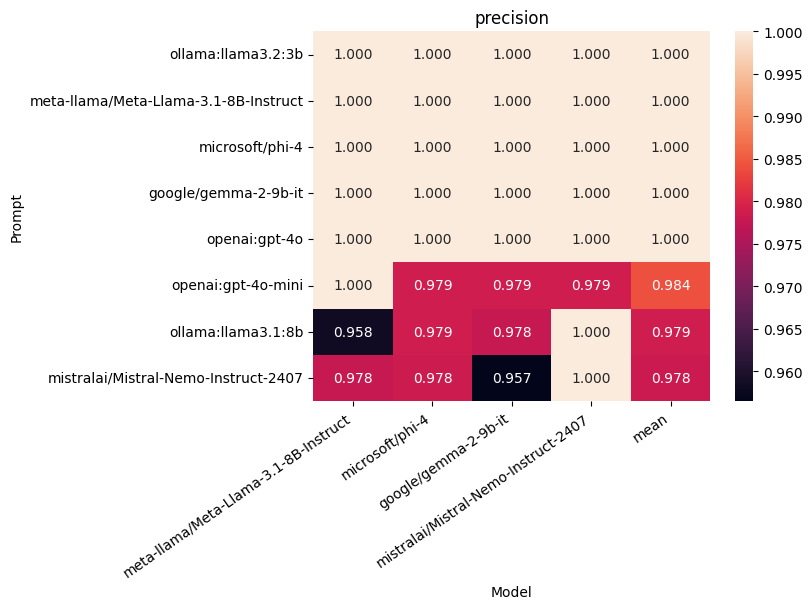

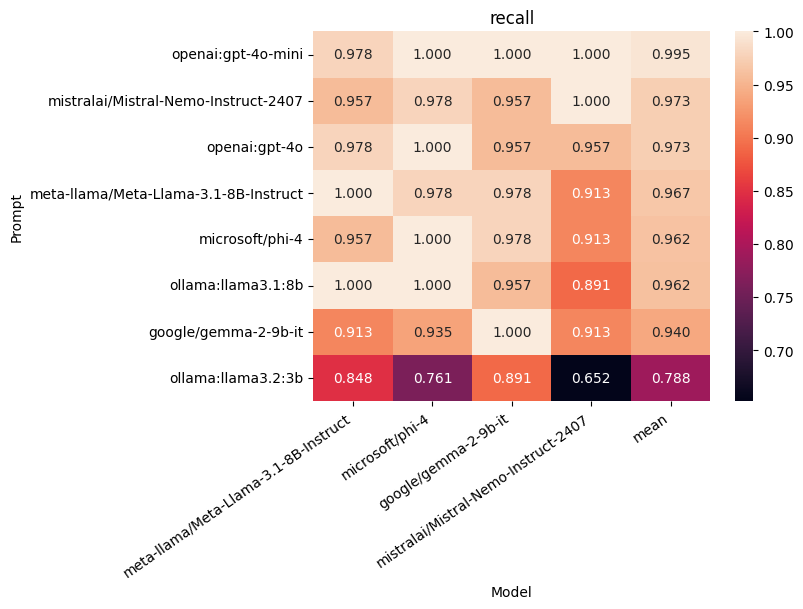

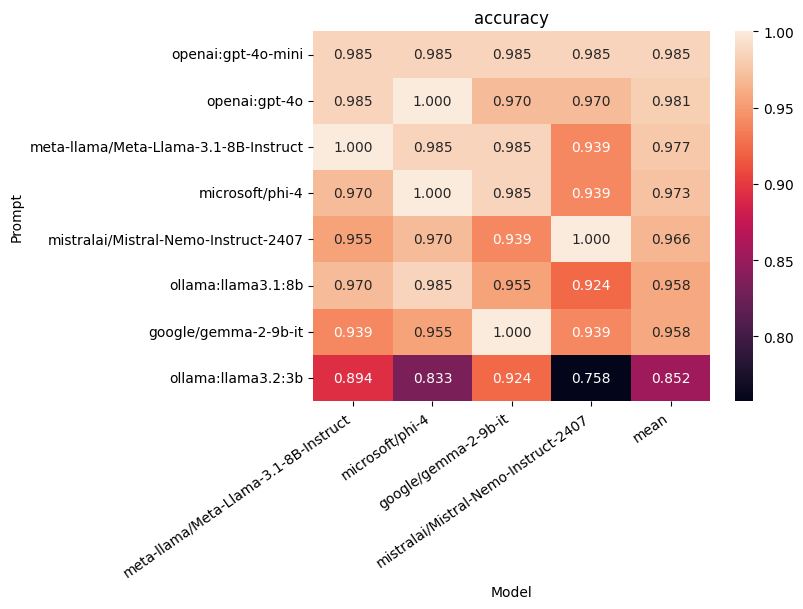

In [58]:
import matplotlib.pyplot as plt

for key, df in dfs.items():
    ax = plt.axes()
    ax.set_title(key)
    p = sns.heatmap(df, ax=ax, annot=True, fmt=".3f")
    ax.set_xticklabels(p.get_xticklabels(), rotation=35, horizontalalignment='right')
    plt.show()